# Customer Credit-ability Classification 
##### - using Logistic Regression, Random Forest, XGBoost and LightGBM

_Author_: QH  
_First Version Date: 2022-01-18_  
_Latest update on: 2022-12-07_

The objective of this project is to classify customer's creditability based on German Credit data using very commonly used classification methods in Machine Learning. Sections are arranged as follows:
1. Data Dictionary of German Credit data to understand the metadata
2. Python libraries versions and helper functions used in this analysis
3. Exploratory Analysis to better understand the data
4. Classification
    * Logistic Regression
    * Random Forest
    * XGBoost
    * LightGBM
5. Evaluation and Comparison of the classification methods

## Data Dictionary of German Credit Data
The following is the data dictionary for this dataset. Some of the variables have been label encoded (i.e. ordinal encoded):

| Variable Name | Description | Values|Type|
| :--|:-- | :-- |:--|
|`Creditability`|Credit-worthiness of a client|1: credit-worthy <br> 0: not credit-worth|Target Variable|
|`Account Balance`|Balance of current account|1: no running account <br> 2: no balance or debit <br> 3: 0 <= ... < 200 DM <br> 4: ... >= 200 DM for checking account for at least 1 year|Ordinal|
|`Duration of Credit (month)`|Duration in months (metric)|-|Numeric|
|`Payment Status of Previous Credit`|Payment of previous credits|0：hesitant payment of previous credits <br> 1: problematic running account / there are further credits running but at other banks <br> 2: no previous credits / paid back all previous credits <br> 3: no problems with current credits at this bank <br> 4: paid back previous credits at this bank|Nominal|
|`Purpose`|Purpose of Credit|0:other <br> 1:new car <br> 2:used car <br> 3:items of furniture <br> 4:radio / television <br> 5:household appliances <br> 6:repair <br> 7:education <br> 8:vacation <br> 9:retraining <br> 10:business|Nominal|
|`Credit Amount`|Amount of credit|-|Numeric|
|`Value Savings/Stocks`|Value of savings or stocks|1:not available / no savings <br> 2: < 100 DM <br> 3: 100 <= ... < 500 - DM <br> 4:500 <= ... < 1000 DM <br> 5: >= 1000 DM|Ordinal|
|`Length of current employment`|Has been employed by current employer for|1: unemployed <br> 2: <= 1 year <br> 3: 1 <= ... < 4 years <br> 4: 4 <= ... < 7 years <br> 5: >= 7 years|Ordinal|
|`Instalment per cent`|Instalment in % of available income|1:>= 35 <br> 2: 25 <= ... < 35 <br> 3:20 <= ... < 25 <br> 4: < 20 |Ordinal|
|`Sex & Marital Status`|Marital Status/Sex|1: male: divorced / living apart <br> 2: male: single <br> 3: male: married / widowed <br> 4: female|Nominal|
|`Guarantors`|Further debtors / Guarantors|1: none <br> 2: Co-Applicant <br> 3: Guarantor|Ordinal|
|`Duration in Current address`|Living in current household for|1: < 1 year <br> 2: 1 <= ... < 4 years <br> 3: 4 <= ... < 7 years <br> 4: >= 7 years|Ordinal|
|`Most valuable available asset`|Most valuable available assets|1: not available / no assets <br> 2: Car / Other <br> 3: Savings contract with a building society / Life insurance <br> 4: Ownership of house or land|Nominal/Ordinal|
|`Age (years)`|Age in years|-|Numeric|
|`Concurrent Credits`|Further running credits|1: at other banks <br> 2: at department store or mail order house <br> 3: no further running credits|Nominal/Ordinal|
|`Type of apartment`|Type of apartment|1: rented flat <br> 2: owner-occupied flat <br> 3: free apartment|Nominal/Ordinal|
|`No. of Credits at this Bank`|Number of previous credits at this bank including the running one|1: one <br> 2: two or three <br> 3: four or five <br> 4: six or more|Ordinal|
|`Occupation`|Occupation|1: unemployed / unskilled with no permanent residence <br> 2: unskilled with permanent residence <br> 3: skilled worker / skilled employee / minor civil servant <br> 4: executive / self-employed / higher civil servant|Nominal/Ordinal|
|`No of dependents`|Number of persons entitled to maintenance|1: 0 - 2 <br> 2: 3 and more |Ordinal|
|`Telephone`|Whether he/she has a telephone?|1: no <br> 2: yes|Nominal|
|`Foreign Worker`|Whether he/she is a foreign worker?|1: yes <br> 2:no|Nominal|

## Python and Library Versions

Import the packages needed for the analysis and print out the versions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
import scipy
import xgboost as xgb
import category_encoders as ce
import graphviz

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from itertools import product

# import utility functions
import sys
import os
# setting path
sys.path.append('..')
from py_util import util, preprocessing_util as prep

In [2]:
print('Python version: ' + sys.version)
package_dict = {'Pandas': pd, 'Numpy': np, 'Matplotlib': matplotlib, 'Seaborn': sns, 
'Scikit-Learn': sklearn, 'SciPy': scipy, 'xgboost': xgb, 'category_encoders': ce, 'graphviz': graphviz}
util.print_version(package_dict)

Python version: 3.9.4 (v3.9.4:1f2e3088f3, Apr  4 2021, 12:32:44) 
[Clang 6.0 (clang-600.0.57)]
Pandas: 1.4.3
Numpy: 1.23.2
Matplotlib: 3.5.3
Seaborn: 0.11.2
Scikit-Learn: 1.1.2
SciPy: 1.9.0
xgboost: 1.6.1
category_encoders: 2.5.1.post0
graphviz: 0.20.1


## Helper functions


In [ ]:
def plot_confusion_matrix(clf, X, y):
    """This function is used to plot Confusion Matrix.

    Parameters
    ----------
    clf: scikit-learn classification estimator object
       The estimator of the classification method
    X: pandas.DataFrame, ndarray 
       Feature dataset
    y: pandas.series, array
       Target variable
    """

    y_pred = clf.predict(X)
    cm = confusion_matrix(y,y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    n_classes = cm.shape[0]
    im_ = ax.imshow(cm, interpolation='nearest', cmap='GnBu', alpha=0.8)
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)
    text_ = np.empty_like(cm, dtype=object)
    # print text with appropriate color depending on background
    thresh = (cm.max() + cm.min()) / 2.0
    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        text_cm = format(cm[i, j], '.2g')
        if cm.dtype.kind != 'f':
            text_d = format(cm[i, j], 'd')
            if len(text_d) < len(text_cm):
                text_cm = text_d
        text_[i, j] = ax.text(j, i, text_cm, ha="center", va="center",color=color)
        
    display_labels = np.arange(n_classes)
    fig.colorbar(im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    ax.set_title('confusion matrix')
    plt.setp(ax.get_xticklabels(), rotation='horizontal')
    plt.show()

In [7]:
def plot_feature_importance(estimator, feature_names, encode_cat_list):
    """
    The function is used to plot the feature importance from most important to least
    for logistic regresssion and tree-based method: random forest, bagging, boosting.
    Logistic Regression: Feature importance is using the absolute value of the coefficient (Condition on that the dataset is standardized)
    Tree-based Methods: Feature importance is based on the 
    If there are one-hot encoding categorical variables, the plot will group these variables together.
    Parameters
    ----------
    estimator: A fitted scikit-learn estimator object
    features_names: array
                    Feature names of the dataset
    """
    if type(estimator) == type(sklearn.linear_model.LogisticRegression()):
        importance_array = estimator.coef_.reshape(-1)
    else:
        importance_array = estimator.feature_importance_.reshape(-1)
    
    importance_df = pd.DataFrame({'var_name_lvl2':np.array(feature_names), 'import_v': importance_array})
    # identify the encoding categorical variables
    importance_df['var_name_lvl1'] = np.where(importance_df['var_name_lvl2'].str.split('_').str[0].isin(encode_cat_list), 
    importance_df['var_name_lvl2'].str.split('_').str[0], importance_df['var_name_lvl2'])
    importance_df['import_v_abs'] = np.abs(importance_df['import_v'])
    import_abs_max = importance_df.groupby('var_name_lvl1', as_index=False)['import_v_abs'].max().rename(columns={'import_v_abs': 'import_v_abs_max'})
    importance_df = importance_df.merge(import_abs_max, on='var_name_lvl1')
    importance_df['color'] = np.where(importance_df['import_v'] < 0, '#CE7777', 'steelblue')
    importance_df_plot = importance_df.sort_values(by=['import_v_abs_max', 'coef_abs'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 8))
    pos = np.arrange(len(importance_array)) + 0.5
    ax.barh(y=pos, width=importance_df_plot['import_v_abs'], color=importance_df_plot['color'], align="center")
    ax.set_yticks(pos, importance_df_plot['var_name_lvl2'])
    ax.set_title('Feature Importance')
    #plt.xticks(rotation=90)
    plt.show()

## Exploratory Analysis

First, we read in the dataset.

In [4]:
# read-in dataset
german_credit_ds = pd.read_csv("german_credit.csv")

Get the data information. As can be seen from the following there are in total 1000 observations and 21 columns with no missing data.

In [5]:
german_credit_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

In [6]:
# Take a look at the data
german_credit_ds.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


### Univariate Analysis

We first split the numeric variables, categorical variables and target variables.

In [9]:
# Columns of the data: Creditability is the target variable
variables = prep.split_num_cat_target(german_credit_ds, 'Creditability', lvl_theta=10)
variables

{'categorical': ['Account Balance',
  'Payment Status of Previous Credit',
  'Purpose',
  'Value Savings/Stocks',
  'Length of current employment',
  'Instalment per cent',
  'Sex & Marital Status',
  'Guarantors',
  'Duration in Current address',
  'Most valuable available asset',
  'Concurrent Credits',
  'Type of apartment',
  'No of Credits at this Bank',
  'Occupation',
  'No of dependents',
  'Telephone',
  'Foreign Worker'],
 'target': ['Creditability'],
 'id': [],
 'numeric': ['Duration of Credit (month)', 'Credit Amount', 'Age (years)']}

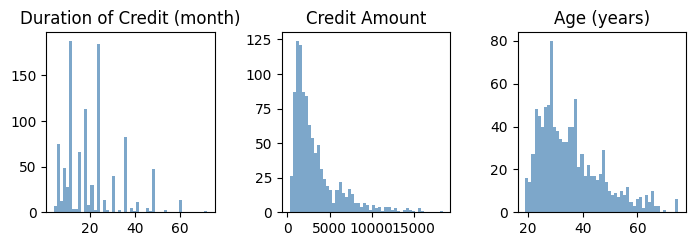

In [10]:
# Descriptive stats for the features
prep.plot_all_dist(german_credit_ds, (8, 2), variables['numeric'], 1, 3)

From the histogram of the numeric variables, it is noticable that all of them are not normally distributed. We can try to do a log transformation on the variables.

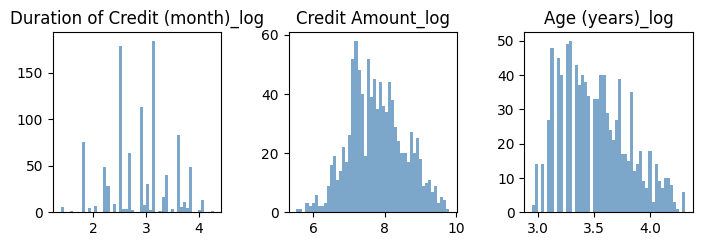

In [14]:
log_trans_df = german_credit_ds[variables['numeric']].astype(float).apply(lambda x: np.log(x + 0.0), axis = 1, result_type = 'broadcast')
log_trans_df.rename(columns={'Duration of Credit (month)':'Duration of Credit (month)_log',
'Credit Amount': 'Credit Amount_log', 'Age (years)': 'Age (years)_log'}, inplace=True)
# plot the newly generated data
prep.plot_all_dist(log_trans_df, (8, 2), ['Duration of Credit (month)_log', 'Credit Amount_log', 'Age (years)_log'], 1, 3)

We can then calculate the average of each numeric variable against the creditability variable. It is straightforwarrd to see the longer the credit,the larger the credit amount and smaller the age, the lower the creditability.

In [16]:
numeric_features = pd.concat([german_credit_ds[variables['target'] + variables['numeric']], log_trans_df], axis=1)
numeric_features.groupby('Creditability').median()

,Duration of Credit (month),Credit Amount,Age (years),Duration of Credit (month)_log,Credit Amount_log,Age (years)_log
Creditability,,,,,,
0,24.0,2574.5,31.0,3.178054,7.853409,3.433987
1,18.0,2244.0,34.0,2.890372,7.716014,3.526361


In [26]:
german_credit_ds = pd.concat([german_credit_ds, log_trans_df], axis=1)
german_credit_ds.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Occupation,No of dependents,Telephone,Foreign Worker,Purpose-gp,No of Credits at this Bank-gp,Count,Duration of Credit (month)_log,Credit Amount_log,Age (years)_log
0,1,1,18,4,2,1049,1,2,4,2,...,3,1,1,1,2,1,1,2.890372,6.955593,3.044522
1,1,1,9,4,0,2799,1,3,2,3,...,3,2,1,1,0,2,1,2.197225,7.937017,3.583519
2,1,2,12,2,9,841,2,4,2,2,...,2,1,1,1,9,1,1,2.484907,6.734592,3.135494
3,1,1,12,4,0,2122,1,3,3,3,...,2,2,1,2,0,2,1,2.484907,7.660114,3.663562
4,1,1,12,4,0,2171,1,3,4,3,...,2,1,1,2,0,2,1,2.484907,7.682943,3.637586


We then will plot the bar charts for all the categorical variables.

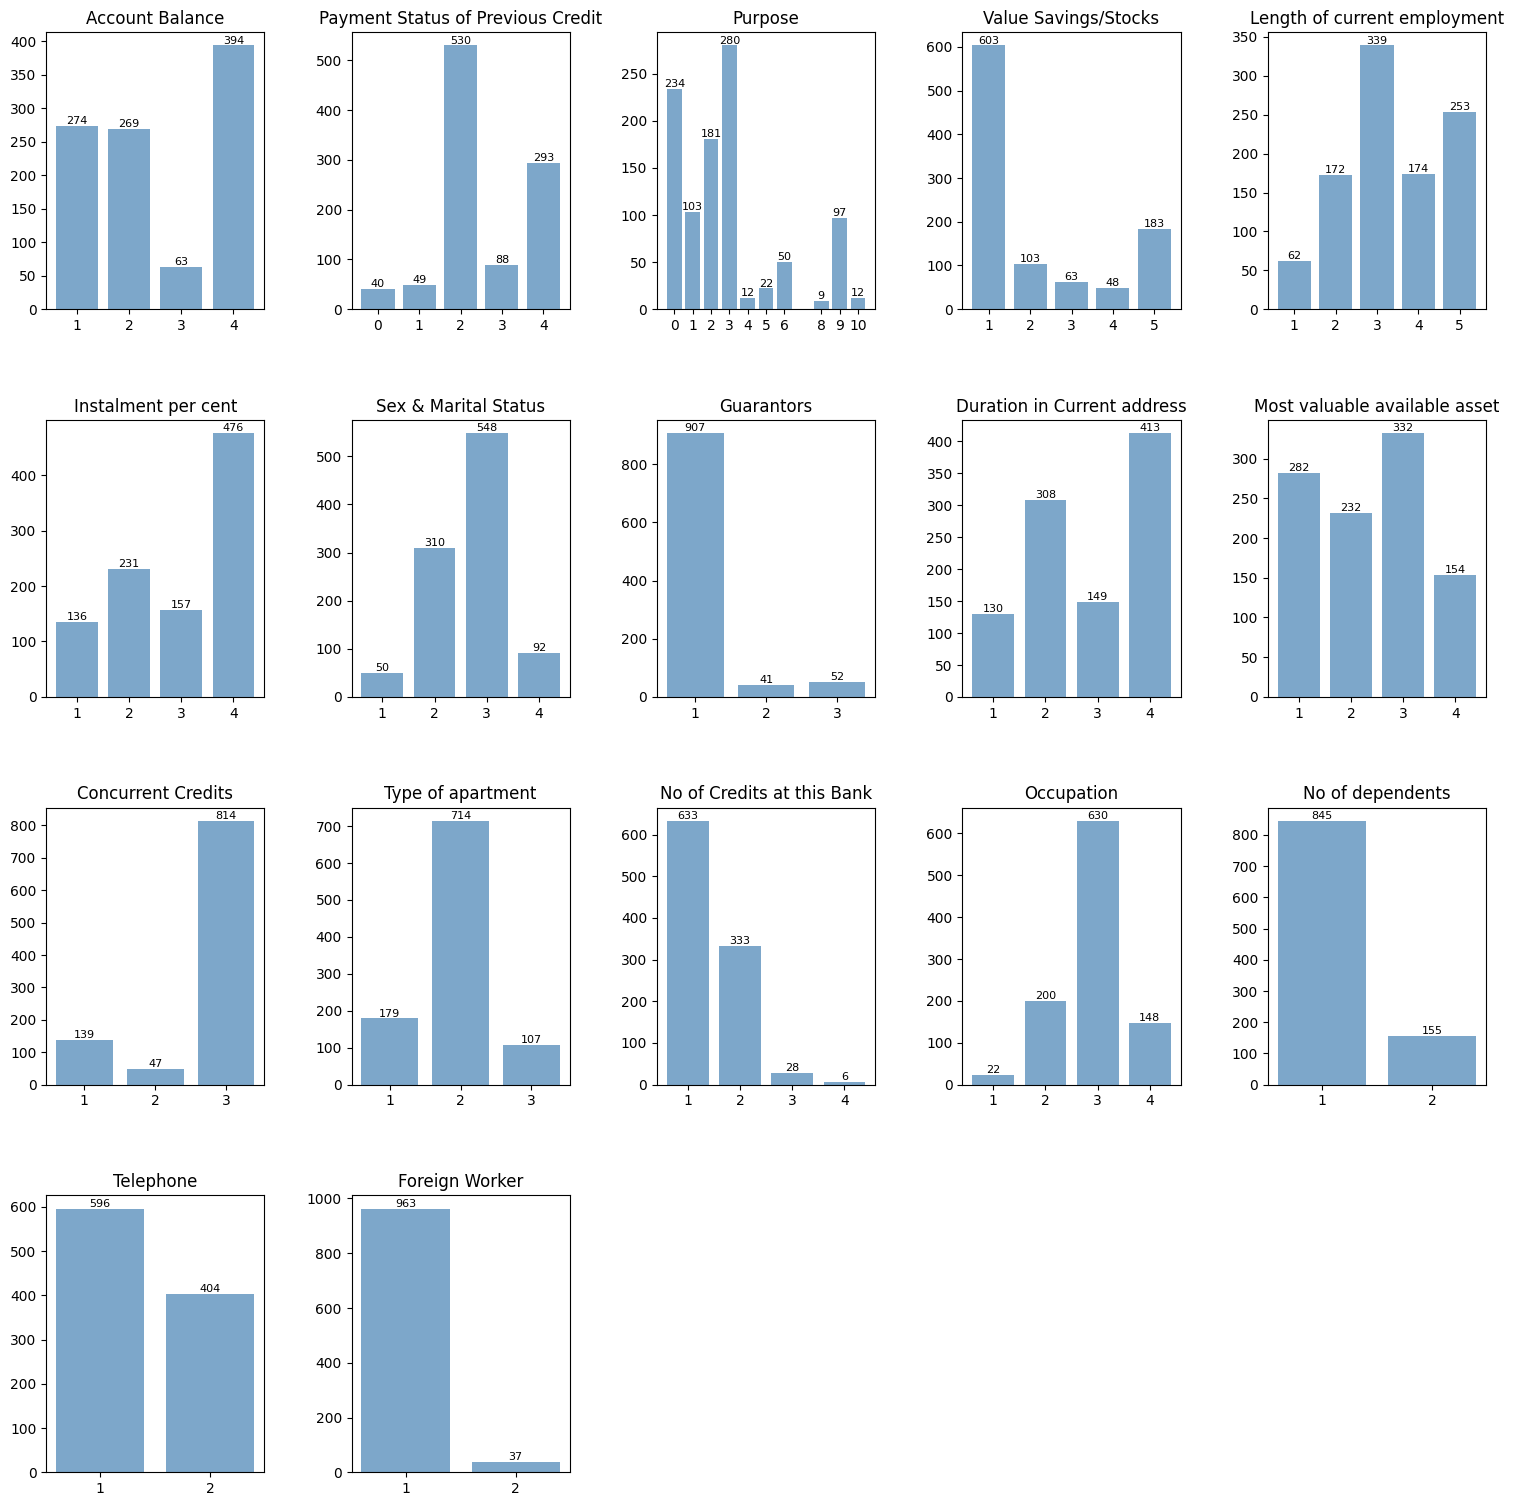

In [27]:
prep.plot_all_freq(german_credit_ds, (18, 16), variables['categorical'], 4, 5, spacing=0.01, fmt="{:.0f}", fontsize=8)

We can notice that for some categories, the number of observations are less than 30 which may lead to less accurate estimation. With that, we need to combine categories for purpose and number of credits for this bank since the number of customers are very small in several categories. Specifically, we will group:
* Purpose = 4, 5 to be 4 as "TV or appliances"
* Purpose = 7, 8, 10 to be 7 as "Education or Business"
* No. of Credits in this bank = 3, 4 to be 3 as "Four or more"

In [28]:
german_credit_ds['Purpose-gp'] = np.where(german_credit_ds['Purpose'].isin([4, 5]), 4,
np.where(german_credit_ds['Purpose'].isin([7, 8, 10]), 7, german_credit_ds['Purpose']))
pd.crosstab(german_credit_ds['Purpose-gp'], german_credit_ds['Purpose'])

Purpose,0,1,2,3,4,5,6,8,9,10
Purpose-gp,,,,,,,,,,
0,234,0,0,0,0,0,0,0,0,0
1,0,103,0,0,0,0,0,0,0,0
2,0,0,181,0,0,0,0,0,0,0
3,0,0,0,280,0,0,0,0,0,0
4,0,0,0,0,12,22,0,0,0,0
6,0,0,0,0,0,0,50,0,0,0
7,0,0,0,0,0,0,0,9,0,12
9,0,0,0,0,0,0,0,0,97,0


In [29]:
german_credit_ds['No of Credits at this Bank-gp'] = np.where(german_credit_ds['No of Credits at this Bank'].isin([3, 4]), 3, german_credit_ds['No of Credits at this Bank'])
# check
pd.crosstab(german_credit_ds['No of Credits at this Bank-gp'], german_credit_ds['No of Credits at this Bank'])

No of Credits at this Bank,1,2,3,4
No of Credits at this Bank-gp,,,,
1,633,0,0,0
2,0,333,0,0
3,0,0,28,6


In [43]:
variables_new = prep.split_num_cat_target(german_credit_ds, 'Creditability', lvl_theta=10)
# Get the numeric variables
num_var_list = variables_new['numeric'].copy()
# Get the categorical variables
cat_var_list = variables_new['categorical'].copy()
cat_var_list.remove('Purpose')
cat_var_list.remove('No of Credits at this Bank')

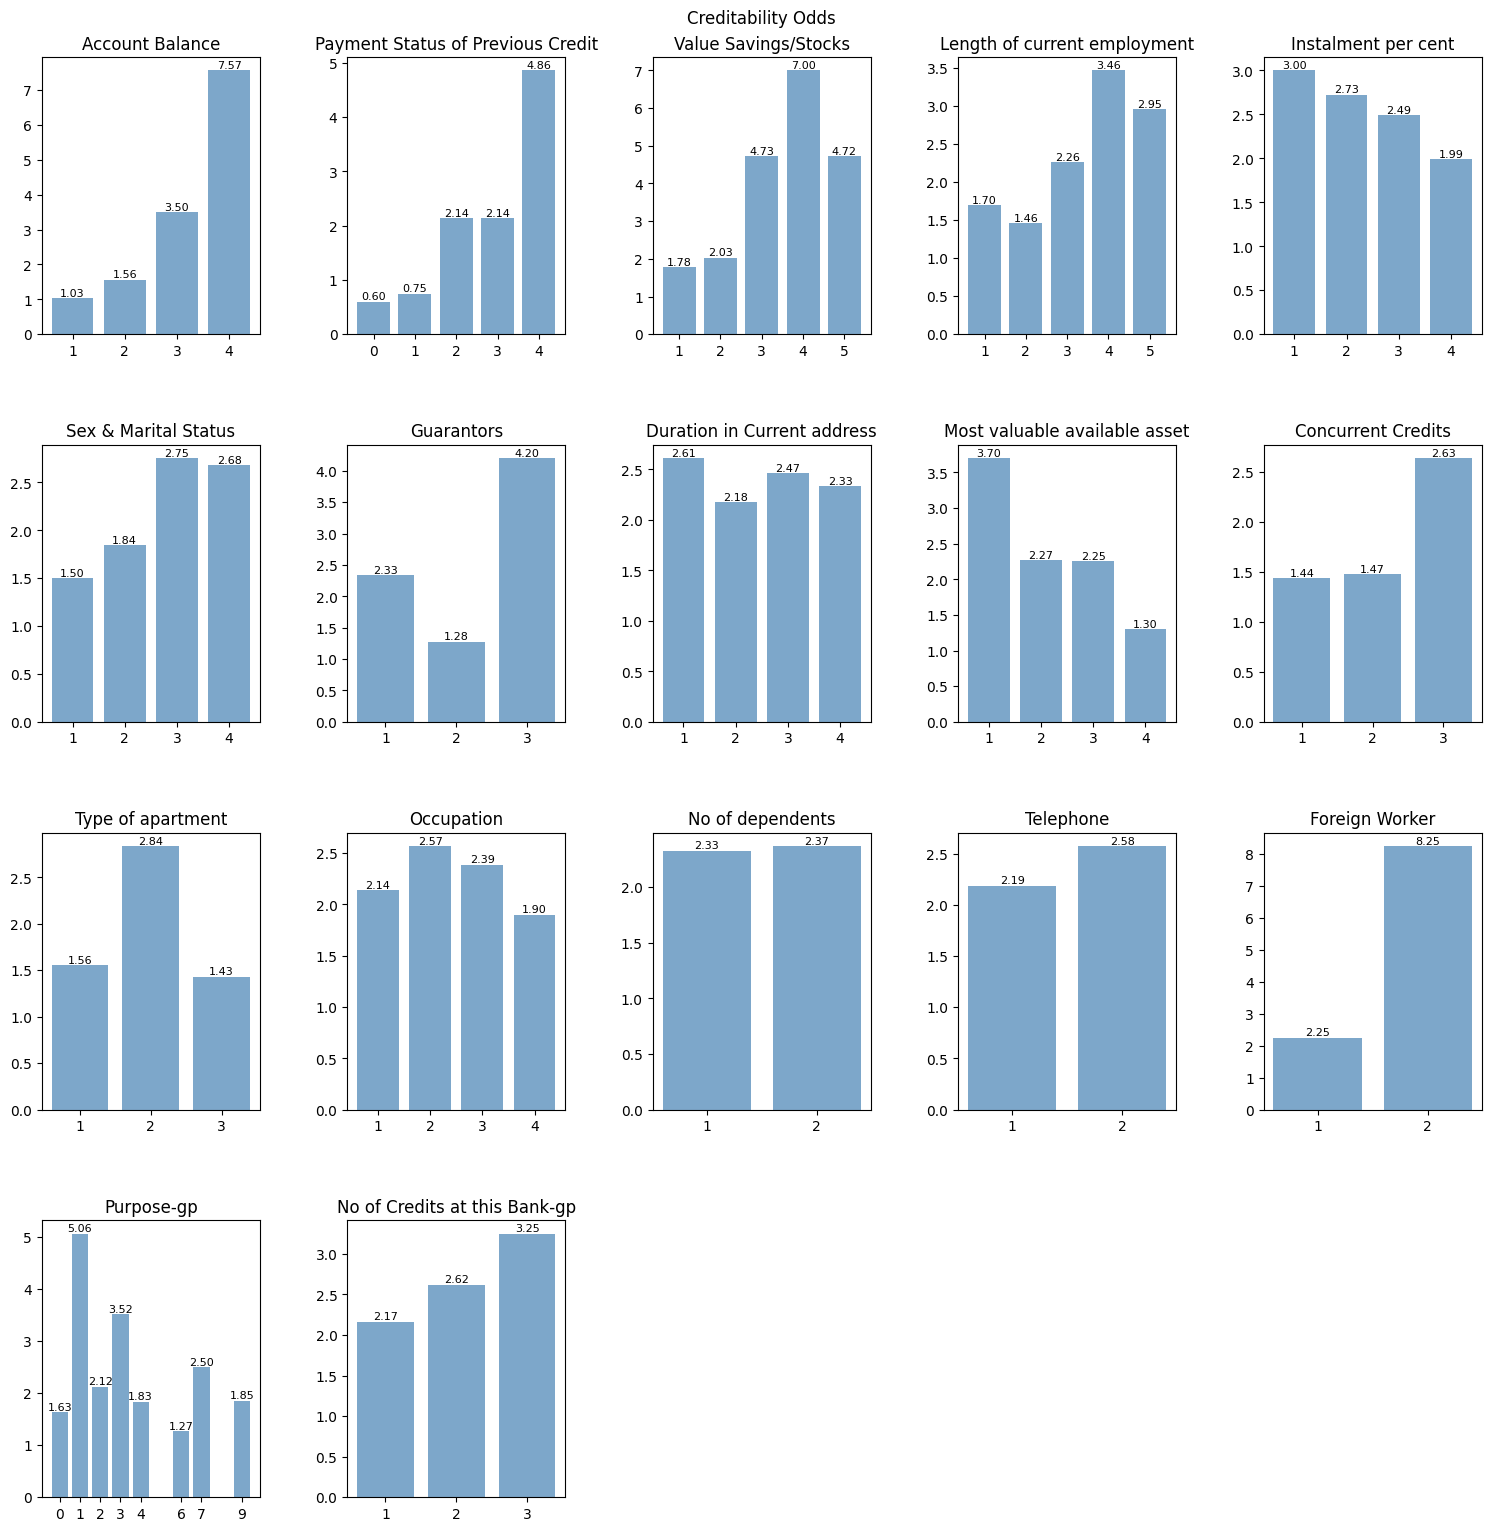

In [45]:
fig = plt.figure(figsize = (18, 16))
row = 4
col = 5
for index in range(1, len(cat_var_list) + 1):
        ax = fig.add_subplot(row, col, index)

        # Calculate odds of the creditability for each category
        cat_var = cat_var_list[index - 1]
        count_df = german_credit_ds.groupby([cat_var, 'Creditability'], as_index=False)['Credit Amount_log'].count().rename(columns={'Credit Amount_log':'Count'})
        total_count_df = german_credit_ds.groupby(cat_var, as_index=False)['Credit Amount_log'].count().rename(columns={'Credit Amount_log':'Total_Count'})
        perc_df = count_df.merge(total_count_df, on=cat_var)
        perc_df['credit_perc'] = perc_df['Count'] / perc_df['Total_Count']
        credit = perc_df.loc[perc_df['Creditability'] == 1, [cat_var, 'credit_perc']].reset_index(drop=True)
        non_credit = perc_df.loc[perc_df['Creditability'] == 0, [cat_var, 'credit_perc']].reset_index(drop=True)
        x = credit[cat_var].values
        height = (credit['credit_perc'] / non_credit['credit_perc']).values

        # Create bar plot
        ax.bar(x=x, height=height, color = 'steelblue', alpha = 0.7)
        x.sort()
        ax.set_xticks(x)
        ax.set_title(cat_var)
        prep.add_value_labels(ax, spacing=0.01, fmt="{:.2f}", fontsize=8 )
        plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                           right=0.9,
                           top=0.95,
                            wspace=0.4,
                            hspace=0.4)
        plt.suptitle('Creditability Odds')
plt.show()

### Multivariate analysis

In [40]:
# Correlations between numeric variables
# Numeric variables are Duration of Credit (month), Credit Amount, Age (years)

german_credit_ds[num_var_list].corr()

,Duration of Credit (month),Credit Amount,Age (years),Duration of Credit (month)_log,Credit Amount_log,Age (years)_log
Duration of Credit (month),1.000000,0.624988,-0.037550,0.945694,0.640816,-0.028431
Credit Amount,0.624988,1.000000,0.032273,0.558987,0.901365,0.038841
Age (years),-0.037550,0.032273,1.000000,-0.060301,0.010781,0.985353
Duration of Credit (month)_log,0.945694,0.558987,-0.060301,1.000000,0.622254,-0.049655
Credit Amount_log,0.640816,0.901365,0.010781,0.622254,1.000000,0.023313
Age (years)_log,-0.028431,0.038841,0.985353,-0.049655,0.023313,1.000000


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(german_credit_ds[num_var_list].values, i) for i in range(german_credit_ds[num_var_list].shape[1])]
vif

[5.5323468915095075, 3.8620727979931178, 3.0648700945210123]

In [18]:
from scipy.stats import chi2_contingency

def cat_var_ind_test(df, cat_var_list):
    chi2_dict = {}
    p_dict = {}
    for i in range(len(cat_var_list)):
        cat_i = cat_var_list[i]
        chi2_dict[cat_i] = []
        p_dict[cat_i] = []
        for j in range(len(cat_var_list)):
            cat_j = cat_var_list[j]
            cross_table = pd.crosstab(df[cat_i], df[cat_j])
            chi2, p, dof, expected = chi2_contingency(cross_table)
            chi2_dict[cat_i].append(chi2)
            p_dict[cat_i].append(p)
    return chi2_dict, p_dict

chi2_dict, p_dict = cat_var_ind_test(german_credit_ds_new, cat_var_list)
pd.DataFrame(p_dict, index=cat_var_list) > 0.05


,Account Balance,Payment Status of Previous Credit,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Concurrent Credits,Type of apartment,Occupation,No of dependents,Telephone,Foreign Worker,Purpose-gp,No of Credits at this Bank-gp
Account Balance,False,False,False,False,True,True,False,False,False,True,False,False,True,True,True,False,False
Payment Status of Previous Credit,False,False,True,False,True,False,True,True,True,False,False,True,False,True,True,False,False
Value Savings/Stocks,False,True,False,False,True,True,False,True,True,True,True,True,True,True,True,False,True
Length of current employment,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False
Instalment per cent,True,True,True,False,False,False,True,True,True,True,True,True,True,True,False,False,True
Sex & Marital Status,True,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False
Guarantors,False,True,False,True,True,True,False,True,False,True,True,False,True,True,False,False,True
Duration in Current address,False,True,True,False,True,False,True,False,False,True,False,True,True,False,True,False,False
Most valuable available asset,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True
Concurrent Credits,True,False,True,True,True,True,True,True,False,False,False,False,True,True,True,False,True


In [19]:

# Categorical variables that are used for encoding:
encode_cat_list = ['Value Savings/Stocks', 'Guarantors', 'Sex & Marital Status', 'Purpose-gp', 'Occupation', 'Type of apartment']
selected_var_list = ['Creditability'] + num_var_list + cat_var_list 
print(selected_var_list)
print(len(selected_var_list))

['Creditability', 'Duration of Credit (month)_log', 'Credit Amount_log', 'Age (years)_log', 'Account Balance', 'Payment Status of Previous Credit', 'Value Savings/Stocks', 'Length of current employment', 'Instalment per cent', 'Sex & Marital Status', 'Guarantors', 'Duration in Current address', 'Most valuable available asset', 'Concurrent Credits', 'Type of apartment', 'Occupation', 'No of dependents', 'Telephone', 'Foreign Worker', 'Purpose-gp', 'No of Credits at this Bank-gp']
21


In [20]:
# Original
german_credit_selected = german_credit_ds_new[selected_var_list]
# One-hot encoding for nominal variables
encoder = ce.OneHotEncoder(cols = encode_cat_list, handle_unknown='return_nan', return_df=True, use_cat_names=True)
german_credit_ds_encoded=encoder.fit_transform(german_credit_selected)
german_credit_ds_encoded.head()

,Creditability,Duration of Credit (month)_log,Credit Amount_log,Age (years)_log,Account Balance,Payment Status of Previous Credit,Value Savings/Stocks_1.0,Value Savings/Stocks_2.0,Value Savings/Stocks_3.0,Value Savings/Stocks_5.0,...,Foreign Worker,Purpose-gp_2.0,Purpose-gp_0.0,Purpose-gp_9.0,Purpose-gp_3.0,Purpose-gp_1.0,Purpose-gp_7.0,Purpose-gp_4.0,Purpose-gp_6.0,No of Credits at this Bank-gp
0,1,2.890372,6.955593,3.044522,1,4,1.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,2.197225,7.937017,3.583519,1,4,1.0,0.0,0.0,0.0,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1,2.484907,6.734592,3.135494,2,2,0.0,1.0,0.0,0.0,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,1,2.484907,7.660114,3.663562,1,4,1.0,0.0,0.0,0.0,...,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,1,2.484907,7.682943,3.637586,1,4,1.0,0.0,0.0,0.0,...,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [4]:
from sklearn.preprocessing import StandardScaler
data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler = StandardScaler()
print(scaler.fit(data))
print(scaler.var_)

StandardScaler()
[0.25 0.25]


In [75]:
X_orig, y = german_credit_ds_encoded.iloc[:,1:], german_credit_ds_encoded.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.3, random_state=0)

# Standardize transformed the training and testing data after the split.
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# Transform X_test using the mean and variance of training data
X_test = scaler.transform(X_test)

## Logistic Regression

In [76]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Defined the parameters
solver = ['lbfgs', 'liblinear']
penalty = ['l2']
c = [100, 10, 1.0, 0.3, 0.1, 0.01]
max_iter = [10000]
params = {'solver': solver, 'penalty': penalty, 'C': c, 'max_iter': max_iter}


# Create the logistic regression model
clf = LogisticRegression()

# Cross validation generator
#cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 0)
cv_repeat = RepeatedStratifiedKFold(n_splits = 5, n_repeats=3, random_state = 0)

# Grid Search the best parameter for the solver and c
grid_search = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1, cv=cv_repeat, scoring='roc_auc')
grid_search_result = grid_search.fit(X_train, y_train)

# Output results
print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
# Fit the final model
best_param = grid_search_result.best_params_
final_logit_model = LogisticRegression(solver=best_param['solver'], penalty='l2', C=best_param['C'], max_iter=10000, random_state=0 )
final_logit_model.fit(X_train, y_train)
y_train_pred = final_logit_model.predict_proba(X_train)
y_test_pred = final_logit_model.predict_proba(X_test)
print(f'Trainig AUC Score: {roc_auc_score(y_train, y_train_pred[:, 1])}')
print(f'Test AUC Score: {roc_auc_score(y_test, y_test_pred[:, 1])}')


Best: 0.777900 using {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Trainig AUC Score: 0.82313
Test AUC Score: 0.8055


feature importance by the coefficients

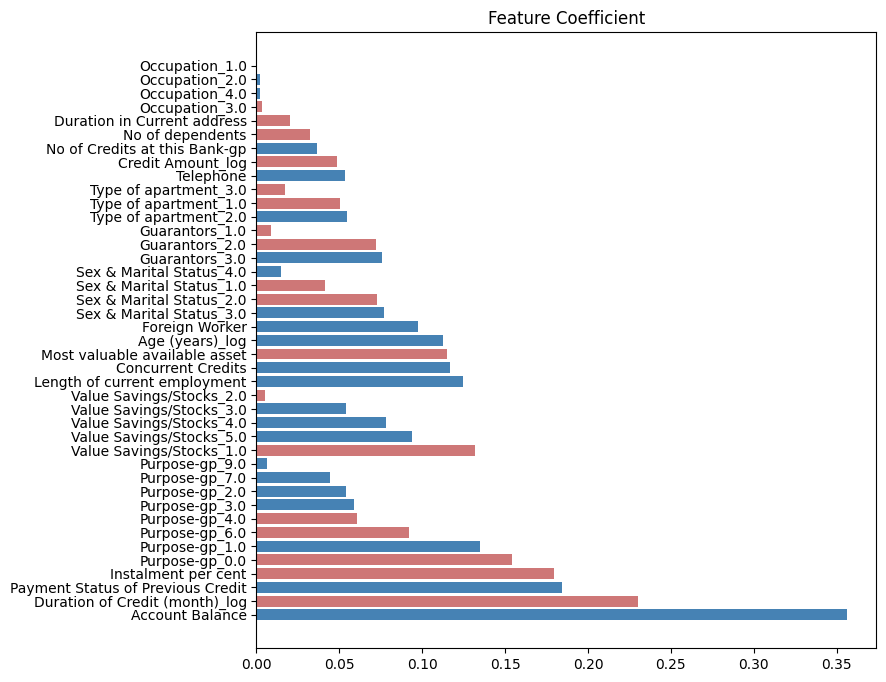

In [162]:
coef_array = final_logit_model.coef_.reshape(-1)
columns_array = german_credit_ds_encoded.columns[1:]
coef_array_abs = np.abs(coef_array)
coef_df = pd.DataFrame({'var_name_lvl2':german_credit_ds_encoded.columns[1:], 'coef': final_logit_model.coef_.reshape(-1)})
coef_df['var_name_lvl1'] = np.where(coef_df['var_name_lvl2'].str.split('_').str[0].isin(encode_cat_list), 
coef_df['var_name_lvl2'].str.split('_').str[0], coef_df['var_name_lvl2'])
coef_df['coef_abs'] = np.abs(coef_df['coef'])
coef_abs_max = coef_df.groupby('var_name_lvl1', as_index=False)['coef_abs'].max().rename(columns={'coef_abs': 'coef_abs_max'})
coef_df = coef_df.merge(coef_abs_max, on='var_name_lvl1')
coef_df['color'] = np.where(coef_df['coef'] < 0, '#CE7777', 'steelblue')
coef_df_plot = coef_df.sort_values(by=['coef_abs_max', 'coef_abs'], ascending=False)
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(y=coef_df_plot['var_name_lvl2'], width=coef_df_plot['coef_abs'], color=coef_df_plot['color'])
ax.set_title('Feature Importance')
#plt.xticks(rotation=90)
plt.show()

## Random Forest

In [192]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Defined the parameters[int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)]
criterion = ['gini']
max_depth = [int(x) for x in np.linspace(1, 10, num=10)]
min_samples_split = [2, 4, 6, 8]
min_samples_leaf = [1, 3, 5, 7]
max_features = ['sqrt', 'log2']
bootstrap = [True]
oob_score = [True]
max_samples = [0.1, 0.3, 0.5, 0.7, 0.9, 1]

params = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'bootstrap': bootstrap, 'oob_score': oob_score, 'max_samples': max_samples}


# Create the RandomForest model
clf = RandomForestClassifier()

# Cross validation generator
#cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 0)
cv_repeat = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2, random_state = 0)

# Randomized Search the best parameter for the solver and c
random_search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter = 100, n_jobs=-1, cv=cv_repeat, scoring='roc_auc')
random_search_result = random_search.fit(X_train, y_train)

# Output results
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

# Fit the final model
best_param = random_search_result.best_params_
final_rf_model = RandomForestClassifier(n_estimators=best_param['n_estimators'], # The number of trees in the forest.i.e. number of bagging samples B.
                            criterion=best_param['criterion'], # Use 'Gini' as the objective function for the recursive-binary-split
                            max_depth=best_param['max_depth'], # The maximum depth of the tree
                            min_samples_split=best_param['min_samples_split'], # The minimum number of samples required to split an internal node.
                            min_samples_leaf=best_param['min_samples_leaf'], # The minimum number of samples required to be at a leaf node.
                            max_features=best_param['max_features'], # the number of features to consider at each split: m = sqrt(p).
                            bootstrap=best_param['bootstrap'], # Whether bootstrap samples are used when building trees.
                            oob_score=best_param['oob_score'], # Whether to use out-of-bag samples to estimate the generalization score.
                            random_state=23, # Controls both the randomness of the bootstrapping of the samples used when building trees 
                            max_samples=best_param['max_samples'], # If bootstrap is True, the number of samples to draw from X to train each base estim)
)
final_rf_model.fit(X_train, y_train)
y_train_pred = final_rf_model.predict_proba(X_train)
y_test_pred = final_rf_model.predict_proba(X_test)
print(f'Trainig AUC Score: {roc_auc_score(y_train, y_train_pred[:, 1])}')
print(f'Test AUC Score: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Best: 0.788125 using {'oob_score': True, 'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.3, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
Trainig AUC Score: 0.9325199999999999
Test AUC Score: 0.81875


feature importance

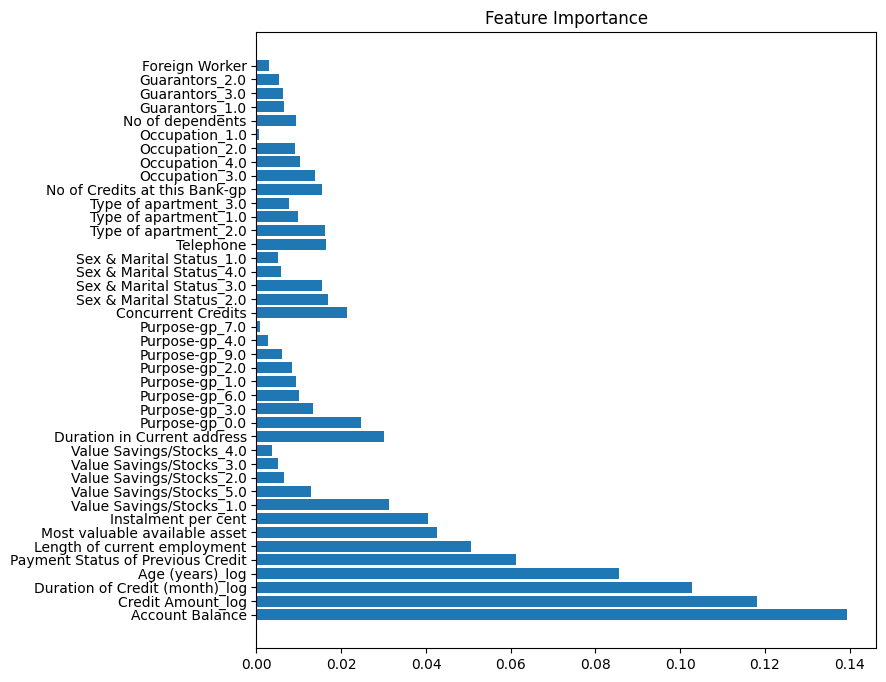

In [155]:

coef_array = final_rf_model.feature_importances_.reshape(-1)
columns_array = german_credit_ds_encoded.columns[1:]
coef_array_abs = np.abs(coef_array)
coef_df = pd.DataFrame({'var_name_lvl2':columns_array, 'coef': coef_array})
coef_df['var_name_lvl1'] = np.where(coef_df['var_name_lvl2'].str.split('_').str[0].isin(encode_cat_list), 
coef_df['var_name_lvl2'].str.split('_').str[0], coef_df['var_name_lvl2'])
coef_df['coef_abs'] = np.abs(coef_df['coef'])
coef_abs_max = coef_df.groupby('var_name_lvl1', as_index=False)['coef_abs'].max().rename(columns={'coef_abs': 'coef_abs_max'})
coef_df = coef_df.merge(coef_abs_max, on='var_name_lvl1')
coef_df_plot = coef_df.sort_values(by=['coef_abs_max', 'coef_abs'], ascending=False)
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(y=coef_df_plot['var_name_lvl2'], width=coef_df_plot['coef'])
ax.set_title('Feature Importance')
plt.show()

## XGBoost

In [85]:
# num_trees: Specify the ordinal number of target tree
#for i in range(0, 10):
#    xgb.plot_tree(xg_logit, num_trees=i, rankdir='LR')
#plt.rcParams['figure.figsize'] = [10, 10]
#plt.show()

In [185]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

# Defined the parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)]
objective = ['binary:logistic']
max_depth = [int(x) for x in np.linspace(1, 5, num=5)]
#max_leaves = [0, 2, 4, 6, 8]
learning_rate = [0.01, 0.05, 0.1, 0.3]
gamma = [0, 0.01, 0.05, 0.1, 0.5]
colsample_bytree = [0.25, 0.3, 0.5, 0.7]
subsample = [0.1, 0.3, 0.5, 0.7, 1]
reg_alpha = [0, 1.0, 3.0]
eval_metric = 'auc'
scale_pos_weight = [0.4]


params = {'n_estimators': n_estimators, 
          'objective': objective, 
          'max_depth': max_depth, 
          #'max_leaves': max_leaves,
          'learning_rate': learning_rate, 
          'gamma': gamma, 
          'colsample_bytree': colsample_bytree,
          'subsample': subsample,
          'reg_alpha': reg_alpha,
          'scale_pos_weight': scale_pos_weight
           }


# Create the RandomForest model
clf = xgb.XGBClassifier()

# Cross validation generator
#cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 0)
cv_repeat = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2, random_state = 23)

# random Search the best parameter for the solver and c
random_search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter = 200, n_jobs=-1, cv=cv_repeat, scoring='roc_auc')
random_search_result = random_search.fit(X_train, y_train)

# Output results
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

# Fit the final model
best_param = random_search_result.best_params_
final_xgb_model = xgb.XGBClassifier(n_estimators=best_param['n_estimators'], # The number of trees in the forest.i.e. number of bagging samples B.
                            objective=best_param['objective'], 
                            max_depth=best_param['max_depth'], 
                            #max_leaves=best_param['max_leaves'],
                            learning_rate=best_param['learning_rate'], 
                            gamma=best_param['gamma'], 
                            colsample_bytree=best_param['colsample_bytree'],
                            subsample=best_param['subsample'],
                            reg_alpha=best_param['reg_alpha'], 
                            scale_pos_weight=best_param['scale_pos_weight'],
                            random_state = 23
)
final_xgb_model.fit(X_train, y_train)
y_train_pred = final_xgb_model.predict_proba(X_train)
y_test_pred = final_xgb_model.predict_proba(X_test)
print(f'Trainig AUC Score: {roc_auc_score(y_train, y_train_pred[:, 1])}')
print(f'Test AUC Score: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Best: 0.797775 using {'subsample': 0.7, 'scale_pos_weight': 0.4, 'reg_alpha': 1.0, 'objective': 'binary:logistic', 'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.7}
Trainig AUC Score: 0.9828199999999999
Test AUC Score: 0.7783


## LightGBM

In [191]:
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

# Defined the parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)]
objective = ['binary']
max_depth = [int(x) for x in np.linspace(1, 5, num=5)]
#num_leaves = [10, 20, 30, 40, 50]
learning_rate = [0.01, 0.05, 0.1, 0.2]
min_split_gain = [0, 0.01, 0.05, 0.075]
colsample_bytree = [0.25, 0.3, 0.5, 0.7]
subsample = [0.1, 0.3, 0.5]
reg_alpha = [0, 0.5, 1.0]
scale_pos_weight = [0.4]


params = {'n_estimators': n_estimators, 
          'objective': objective, 
          'max_depth': max_depth, 
          #'num_leaves': num_leaves,
          'learning_rate': learning_rate, 
          'min_split_gain': min_split_gain, 
          'colsample_bytree': colsample_bytree,
          'subsample': subsample,
          'reg_alpha': reg_alpha,
          'scale_pos_weight':scale_pos_weight
           }


# Create the RandomForest model
clf = lgbm.LGBMClassifier()

# Cross validation generator
#cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 0)
cv_repeat = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2, random_state = 23)

# Randomized Search the best parameter for the solver and c
cv_search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter = 500, n_jobs=-1, cv=cv_repeat, scoring='roc_auc')
cv_search_result = cv_search.fit(X_train, y_train)

# Output results
print("Best: %f using %s" % (cv_search_result.best_score_, cv_search_result.best_params_))

# Fit the final model
best_param = cv_search_result.best_params_
final_lgbm_model = lgbm.LGBMClassifier(n_estimators=best_param['n_estimators'], # The number of trees in the forest.i.e. number of bagging samples B.
                            objective=best_param['objective'], 
                            max_depth=best_param['max_depth'], 
                            #num_leaves=best_param['num_leaves'],
                            learning_rate=best_param['learning_rate'], 
                            min_split_gain=best_param['min_split_gain'], 
                            colsample_bytree=best_param['colsample_bytree'],
                            subsample=best_param['subsample'],
                            reg_alpha=best_param['reg_alpha'], 
                            scale_pos_weight=best_param['scale_pos_weight'],
                            random_state = 23
)
final_lgbm_model.fit(X_train, y_train)
y_train_pred = final_lgbm_model.predict_proba(X_train)
y_test_pred = final_lgbm_model.predict_proba(X_test)
print(f'Trainig AUC Score: {roc_auc_score(y_train, y_train_pred[:, 1])}')
print(f'Test AUC Score: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Best: 0.793800 using {'subsample': 0.3, 'scale_pos_weight': 0.4, 'reg_alpha': 1.0, 'objective': 'binary', 'n_estimators': 200, 'min_split_gain': 0, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.25}
Trainig AUC Score: 0.9377
Test AUC Score: 0.78655
